## Task 1 [3p]

Implement simplified word2vec with negative sampling from scratch (using pure numpy). Assume that in the training data objects and contexts are given explicitly, one pair per line, and objects are on the left; see the [data file](https://drive.google.com/file/d/1WoBT5OrTlNnjHg6jN90RnRb7krpEzFsP/view?usp=drive_link). The result of the training should be object vectors. Please, write them to a file using *natural* text format, ie

<pre>
word1 x1_1 x1_2 ... x1_N 
word2 x2_1 x2_2 ... x2_N
...
wordK xK_1 xK_2 ... xk_N
</pre>

Use the loss with negative sampling (NS) as in [Mikolov et al. 2013](https://arxiv.org/pdf/1310.4546) (see section 2.2). The loss function is as follows:  
Given:  
- A **center word** w_c
A **true context word** w_o
k **negative samples**: words not in the context (denoted as w_1, ..., w_k)
Word vectors:
- v_c = embedding of the center word (from input matrix)
- u_o = embedding of the context word (from output matrix)
- u_i = embeddings of negative samples

$$
 L = -\log \sigma(u_o^T v_c) - \sum_{i=1}^k \log \sigma(-u_i^T v_c);
$$

(see [SKOS info](https://skos.ii.uni.wroc.pl/course/view.php?id=738#section-10) for more details)


Compute the gradient manually. You can use some gradient clipping, or regularizaton.


**Remark**: the data is specially prepared to make the learning process easier. 
Present vectors using the code below. In this task we define success as 'obtaining a result which looks definitely not random'


u - object vector, v - context vector  
o - object, c - conteext   
$P(o|c) = \frac{\exp(u_o^T v_c)}{\sum_{w\in V} \exp(u_w^T v_c)}$

**Negative Sampling:**  
$$J_{neg-sample}(u_o, v_c, u_i) = -\log \sigma(u_o^T v_c) - \sum_{k \in \{\text{K sampled indices}\}} \log \sigma(-u_i^T v_c)$$


___

In [43]:
import numpy as np
import random
from collections import defaultdict
from tqdm.notebook import tqdm

In [44]:
def read_data(filepath):
    pairs = []
    vocab = set()
    with open(filepath, 'r') as f:
        for line in f:
            parts = line.strip().split()
            # safety reasons (should not happen)
            if len(parts) < 2: continue
            center = parts[0]
            context = parts[-1]
            pairs.append((center, context))
            vocab.update([center, context])
    return pairs, sorted(vocab)

def build_vocab(vocab):
    word2idx = {word: idx for idx, word in enumerate(vocab)}
    idx2word = {idx: word for word, idx in word2idx.items()}
    return word2idx, idx2word


In [45]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def get_unigram_distribution(pairs, vocab_size, word2idx):
    word_counts = np.zeros(vocab_size)
    for center, context in pairs:
        word_counts[word2idx[center]] += 1
        word_counts[word2idx[context]] += 1
    unigram_dist = word_counts ** 0.75
    unigram_dist /= unigram_dist.sum()
    return unigram_dist

def get_negative_samples_unigram(context_idx, vocab_size, k, unigram_dist):
    negatives = []
    while len(negatives) < k:
        needed = k - len(negatives)
        samples = np.random.choice(vocab_size, size=needed * 2, p=unigram_dist)
        filtered = [neg for neg in samples if neg != context_idx and neg not in negatives]
        negatives.extend(filtered[:needed])
    return negatives

def get_negative_samples(context_idx, vocab_size, k):
    negatives = []
    while len(negatives) < k:
        neg = random.randint(0, vocab_size - 1)
        if neg != context_idx:
            negatives.append(neg)
    return negatives


def initialize_embeddings(vocab_size, embed_dim):
    input_vectors = np.random.randn(vocab_size, embed_dim) * 0.01
    output_vectors = np.random.randn(vocab_size, embed_dim) * 0.01
    return input_vectors, output_vectors


In [49]:
def train_word2vec(pairs, word2idx, embed_dim=50, epochs=5, lr=0.05, k=5):
    vocab_size = len(word2idx)
    input_vectors, output_vectors = initialize_embeddings(vocab_size, embed_dim)

    unigram_dist = get_unigram_distribution(pairs, vocab_size, word2idx)

    for epoch in range(epochs):
        total_loss = 0
        random.shuffle(pairs)
        pbar = tqdm(pairs, desc=f"Epoch {epoch + 1}")
        
        for center, context in pbar:
            center_idx = word2idx[center]
            context_idx = word2idx[context]

            v_c = input_vectors[center_idx]
            u_o = output_vectors[context_idx]

            # positive sample
            z = np.dot(u_o, v_c)
            p = sigmoid(z)
            grad_vc = (p - 1) * u_o
            grad_uo = (p - 1) * v_c

            # input_vectors[center_idx] -= lr * grad_vc
            output_vectors[context_idx] -= lr * grad_uo

            # negative samples
            neg_indices = get_negative_samples_unigram(context_idx, vocab_size, k, unigram_dist)
            # neg_indices = get_negative_samples(context_idx, vocab_size, k)
            for neg_idx in neg_indices:
                u_k = output_vectors[neg_idx]
                z_neg = np.dot(u_k, v_c)
                p_neg = sigmoid(-z_neg)
                grad_vc += (1 - p_neg) * u_k
                grad_uk = (1 - p_neg) * v_c

                output_vectors[neg_idx] -= lr * grad_uk

            input_vectors[center_idx] -= lr * grad_vc

            loss = -np.log(p + 1e-8) - sum(np.log(sigmoid(-np.dot(output_vectors[neg], v_c)) + 1e-8) for neg in neg_indices)
            total_loss += loss
            pbar.set_postfix(loss=total_loss / (1 + pbar.n))

    return input_vectors, word2idx


In [50]:
def save_vectors(filename, input_vectors, word2idx):
    idx2word = {idx: word for word, idx in word2idx.items()}
    with open(filename, 'w') as f:
        for idx, vector in enumerate(input_vectors):
            word = idx2word[idx]
            vec_str = ' '.join(map(str, vector))
            f.write(f"{word} {vec_str}\n")


In [ ]:
data_file = 'input/task1_objects_contexts_polish.txt'
pairs, vocab = read_data(data_file)
word2idx, _ = build_vocab(vocab)

input_vectors, word2idx = train_word2vec(pairs, word2idx, embed_dim=100, epochs=3, lr=0.05, k=5)

save_vectors('output/vectors.txt', input_vectors, word2idx)

In [35]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

def visualize_embeddings(vectors, word2idx, num_points=100, random_points=True):
    idx2word = {idx: word for word, idx in word2idx.items()}
    pca = PCA(n_components=2)
    if random_points:
        indices = random.sample(range(len(vectors)), num_points)
    else:
        indices = range(num_points)
    reduced = pca.fit_transform(vectors[indices])

    plt.figure(figsize=(12, 10))
    for i in range(num_points):
        plt.scatter(reduced[i, 0], reduced[i, 1], alpha=0.6)
        plt.text(reduced[i, 0], reduced[i, 1], idx2word[i], fontsize=9)
    plt.title("PCA of Word Embeddings")
    plt.grid(True)
    plt.show()


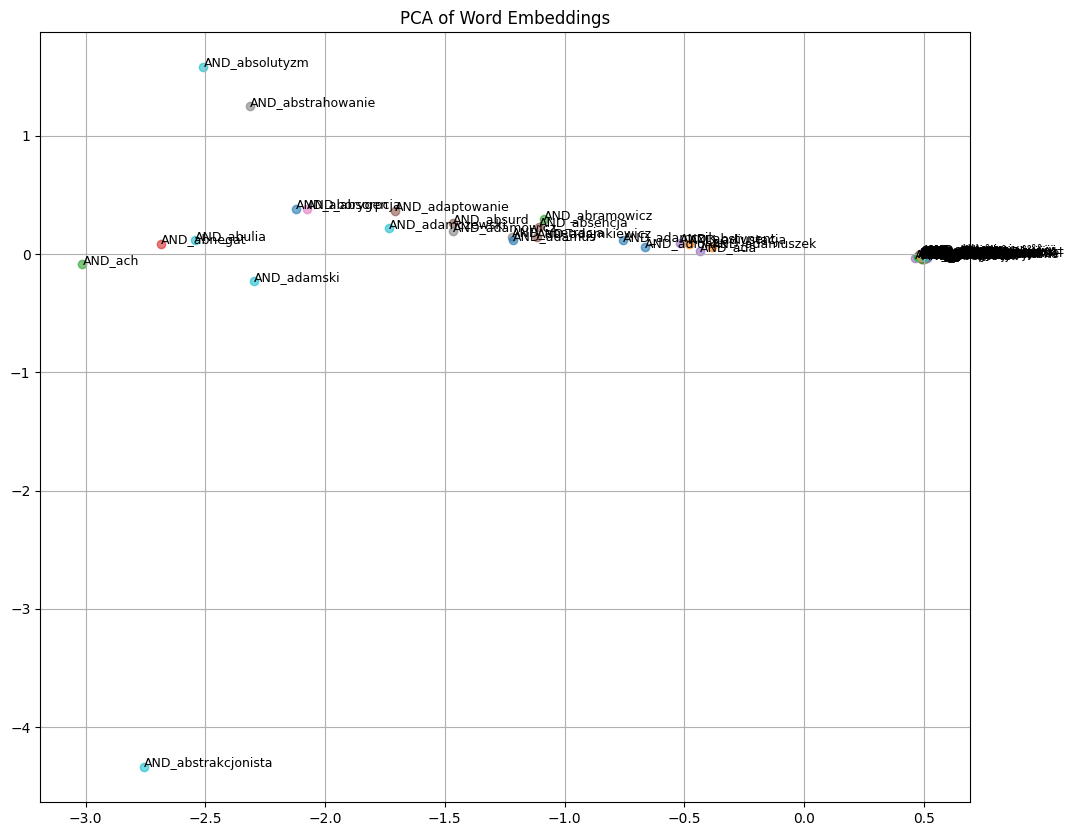

In [36]:
visualize_embeddings(input_vectors, word2idx, num_points=100)


In [42]:
from numpy.linalg import norm

def most_similar(word, input_vectors, word2idx, topn=5):
    if word not in word2idx:
        print(f"Word '{word}' not in vocabulary.")
        return
    print(f"Most similar words to '{word}':")
    idx = word2idx[word]
    vec = input_vectors[idx]
    sims = input_vectors @ vec / (norm(input_vectors, axis=1) * norm(vec) + 1e-8)

    sims[idx] = -np.inf
    idx2word = {idx: w for w, idx in word2idx.items()}
    top_indices = np.argsort(sims)[-topn:][::-1]
    for i in top_indices:
        print(f"{idx2word[i]}: {sims[i]:.4f}")
    print()

most_similar('prezydent', input_vectors, word2idx, topn=5)
most_similar('kawa', input_vectors, word2idx, topn=5)

Most similar words to 'prezydent':
burmistrz: 0.8827
premier: 0.8600
minister: 0.8449
wiceprezydent: 0.8200
radny: 0.8132

Most similar words to 'kawa':
herbata: 0.9696
wÃ³dka: 0.9444
zupa: 0.9371
ciasto: 0.9361
piwo: 0.9355

